# Data Preparation for NN

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from datetime import datetime

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = {
    'tra': pd.read_csv('../input/air_visit_data.csv.gz'),
    'as': pd.read_csv('../input/air_store_info.csv.gz'),
    'hs': pd.read_csv('../input/hpg_store_info.csv.gz'),
    'ar': pd.read_csv('../input/air_reserve.csv.gz'),
    'hr': pd.read_csv('../input/hpg_reserve.csv.gz'),
    'id': pd.read_csv('../input/store_id_relation.csv.gz'),
    'tes': pd.read_csv('../input/sample_submission.csv.gz'),
    'hol': pd.read_csv('../input/date_info.csv.gz').rename(columns={'calendar_date':'visit_date'})
    }

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [3]:
for df in ['ar','hr']:
    data[df]['reserve_visitors'] = np.log1p(data[df]['reserve_visitors'])
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_dow'] = data[df]['visit_datetime'].dt.dayofweek
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    # NEW FEATURE FROM aharless kernel
    data[df]['early_reservation'] = data[df]['reserve_datetime_diff'] > 2
    data[df]['late_reservation'] = data[df]['reserve_datetime_diff'] <= 2
    tmp1 = data[df][data[df]['early_reservation']].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df][data[df]['early_reservation']].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    tmp3 = data[df][data[df]['late_reservation']].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs12', 'reserve_visitors':'rv12'})
    tmp4 = data[df][data[df]['late_reservation']].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs22', 'reserve_visitors':'rv22'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])
    data[df] = pd.merge(data[df], tmp3, how='left', on=['air_store_id','visit_date'])
    data[df] = pd.merge(data[df], tmp4, how='left', on=['air_store_id','visit_date'])

In [4]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
# NEW FEATURE FROM aharless kernel
data['tra']['week'] = data['tra']['visit_date'].dt.week
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [5]:
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['week'] = data['tes']['visit_date'].dt.week
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [6]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 

## Label Encoder

Sklearn Label Encoder simply encode categorical labels with value *between 0 and n_classes-1*. For usage, look at [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [7]:
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='inner', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

In [8]:
# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

## log1p (Log Transformation & plus 1 and logarithm)

*The log transformation can be used to make highly skewed distributions less skewed.* We use log1p (log1p(x) = log(1 + x)) because log(0) = Undefined.

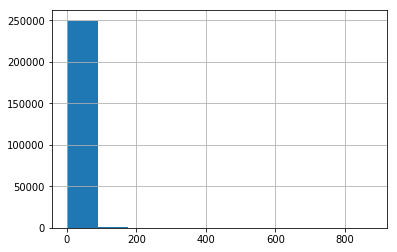

In [9]:
train['visitors'].hist();

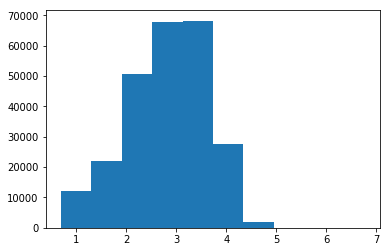

In [10]:
plt.hist(np.log1p(train['visitors']));

In [11]:
# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

train['visitors'] = np.log1p(train['visitors'].values)

Here we prepare data required for the neural network model.

**value_col**:  taken as float input(which are normalized)

**nn_col - value_col**: taken as categorical inputs(embedding layers used)

## Why scale?

Well, most machine learning algorithms take into account only the magnitude of the measurements, not the units of those measurements.
That’s why one feature, which is expressed in a very high magnitude (number), may affect the prediction a lot more than an equally important feature.

Let’s say you have two lengths, l1 = 250 cm and l2 = 2.5 m. We humans see that these two are identical lenghts (l1 = l2), but most ML algorithms interpret this quite differently.

You see, the algo is going to give a lot more weight to l1, just because it is expressed in a larger number , which, in turn is going to have a much larger impact on the prediction than l2.

**NN:** Optimizer Problem and Speed

### MinMaxScaler

**Formula:** *(xi–min(x))/ (max(x)–min(x))*. 

For usage, look at [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [12]:
value_col = ['holiday_flg','min_visitors','mean_visitors','median_visitors','max_visitors','count_observations',
'rs1_x','rv1_x','rs2_x','rv2_x','rs1_y','rv1_y','rs2_y','rv2_y','total_reserv_sum','total_reserv_mean',
'total_reserv_dt_diff_mean','date_int','var_max_lat','var_max_long','lon_plus_lat']

nn_col = value_col + ['dow', 'year', 'month', 'air_store_id2', 'air_area_name', 'air_genre_name',
'air_area_name0', 'air_area_name1', 'air_area_name2', 'air_area_name3', 'air_area_name4',
'air_area_name5', 'air_area_name6', 'air_genre_name0', 'air_genre_name1',
'air_genre_name2', 'air_genre_name3', 'air_genre_name4']

X = train.copy()
X_test = test[nn_col].copy()

value_scaler = preprocessing.MinMaxScaler()
for vcol in value_col:
    X[vcol] = value_scaler.fit_transform(X[vcol].values.astype(np.float64).reshape(-1, 1))
    X_test[vcol] = value_scaler.transform(X_test[vcol].values.astype(np.float64).reshape(-1, 1))

X_train = list(X[nn_col].T.values)
Y_train = X['visitors'].values
nn_train = [X_train, Y_train]
nn_test = [list(X_test[nn_col].T.values)]
print("Train and test data prepared for NN")

Train and test data prepared for NN


## Saving Prepared Data

In [13]:
np.savez_compressed('processed_input/train_features_nn.npz', X_train=nn_train[0], Y_train=nn_train[1])
np.savez_compressed('processed_input/test_features_nn.npz', X_test=nn_test[0])

data['tra'].to_csv('processed_input/train_nn.csv.gz', compression='gzip', index=False)
data['tes'].to_csv('processed_input/test_nn.csv.gz', compression='gzip', index=False)
data['hol'].to_csv('processed_input/date_info_nn.csv.gz', compression='gzip', index=False)

train.to_csv('processed_input/train_attr_nn.csv.gz', compression='gzip', index=False)
test.to_csv('processed_input/test_attr_nn.csv.gz', compression='gzip', index=False)

## References
- https://medium.com/@ian.dzindo01/feature-scaling-in-python-a59cc72147c1